## Practical 2:  Classifying TED Talks
<p>A solution to the task for the Deep Learning for NLP 2017 course.<br>
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/</p>
<p>Tasks created by [Yannis Assael, Brendan Shillingford, Chris Dyer]</p>

This 

In [1]:
import numpy as np
import os
from random import shuffle
import re

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Part 0: Downloading and preprocessing

In [3]:
import urllib.request
import zipfile
import lxml.etree

In [4]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [5]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
all_text = '\n'.join(doc.xpath('//content/text()'))
talkcontent = doc.xpath('//content/text()')
keywords = doc.xpath('//head/keywords/text()')
talks = [(a,b) for (a,b) in zip(talkcontent, keywords)]

The XML is traversed, and for each talk we obtain the text of the talk, as well as associated keywords. 

In [6]:
talk, tag = talks[4]
print ( "[ " + talk[:500] + " ... ]" )
print( "Tagged as: " + tag)

print(len(talks) , "talks parsed.")

[ Thousands of years from now, we'll look back at the first century of computing as a fascinating but very peculiar time -- the only time in history where humans were reduced to live in 2D space, interacting with technology as if we were machines; a singular, 100-year period in the vastness of time where humans communicated, were entertained and managed their lives from behind a screen.
Today, we spend most of our time tapping and looking at screens. What happened to interacting with each other? I ... ]
Tagged as: talks, NASA, communication, computers, creativity, design, engineering, exploration, future, innovation, interface design, invention, microsoft, potential, prediction, product design, technology, visualizations
2085 talks parsed.


This then needs to be reformatted, so that only the relevant keywords are included, and the text content is tokenised in the same manner as the first practical

In [7]:
def to_label(keywords):
    labels = [x.strip() for x in keywords.split(',')]
    
    label1 = "o"
    label2 = "o"
    label3 = "o"
    
    if "technology" in labels:
        label1 = "T"
    if "entertainment" in labels:
        label2 = "E"
    if "design" in labels:
        label3 = "D"
        
    return label1 + label2 + label3

def to_one_hot(label):
    if label == "ooo":
        val = [1,0,0,0,0,0,0,0]
    elif label == "Too":
        val = [0,1,0,0,0,0,0,0]
    elif label == "oEo":
        val = [0,0,1,0,0,0,0,0]
    elif label == "ooD":
        val = [0,0,0,1,0,0,0,0]
    elif label == "TEo":
        val = [0,0,0,0,1,0,0,0]
    elif label == "oED":
        val = [0,0,0,0,0,1,0,0]
    elif label == "ToD":
        val = [0,0,0,0,0,0,1,0]
    elif label == "TED":
        val = [0,0,0,0,0,0,0,1]
    else:
        print("One hot invalid input: ", label)
        val = [0,0,0,0,0,0,0,0]
        
    return np.asarray(val)

In [8]:
processed_talks = list()
labels = list()

for (talk, keywords) in talks:
    input_text_noparens = re.sub(r'\([^)]*\)', '', talk)

    sentences_strings_ted = []

    for line in input_text_noparens.split('\n'):
        m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

    sentences_ted = []
        
    for sent_str in sentences_strings_ted:
        tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
        sentences_ted.extend(tokens)
    
    #There are a couple of talks without any actual parsable content - i.e. id 93. We will skip these
    if(len(sentences_ted) == 0):
        continue
        
    #Process keywords    
    label = to_label(keywords)
    
    processed_talks.append(sentences_ted)
    labels.append(label)


Now all talks are given as a list of tokens, with their keywords.

In [9]:
words = processed_talks[4]
label = labels[4]
print(words[0:50])
print(label)
print(to_one_hot(label))

['thousands', 'of', 'years', 'from', 'now', 'we', 'll', 'look', 'back', 'at', 'the', 'first', 'century', 'of', 'computing', 'as', 'a', 'fascinating', 'but', 'very', 'peculiar', 'time', 'the', 'only', 'time', 'in', 'history', 'where', 'humans', 'were', 'reduced', 'to', 'live', 'in', '2d', 'space', 'interacting', 'with', 'technology', 'as', 'if', 'we', 'were', 'machines', 'a', 'singular', '100', 'year', 'period', 'in']
ToD
[0 0 0 0 0 0 1 0]


In [10]:
for i in range(0,20):
    print (labels[i])

ooo
ooo
ooo
ooD
ToD
ooo
ooo
ooo
ooo
ToD
ooo
ooD
oEo
ToD
ooo
ooo
ooD
ooo
ToD
ooo


### Part 2: Analysis

Randomly permute the dataset, and keep the last two blocks of 250 for validation and testing

In [11]:
zipped = list(zip(processed_talks, labels))

shuffle(zipped)

shuffled_talks, shuffeled_labels = zip(*zipped)

data_training = shuffled_talks[:-500]
labels_training = shuffeled_labels[:-500]
print( str(len(data_training)) + " training items")  

data_testing = shuffled_talks[-500:-250]
labels_testing = shuffeled_labels[-500:-250]
print( str(len(data_testing)) + " testing items") 

data_validation = shuffled_talks[-250:]
labels_validation = shuffeled_labels[-250:]
print( str(len(data_validation)) + " validation items")

test_size = len(data_training)
validation_size = len(data_validation)

1578 training items
250 testing items
250 validation items


In [12]:
# Download the glove embeddings
if not os.path.isfile('glove.zip'):
    urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.zip")

In [13]:
z = zipfile.ZipFile('glove.zip', 'r') 
glove_lines = [ line.decode("utf-8").strip() for line in z.open('glove.6B.50d.txt', 'r').readlines() ] 
z.extract('glove.6B.50d.txt')

'F:\\deeplearning\\glove.6B.50d.txt'

In [14]:
print(glove_lines[0])

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581


In [15]:
import tensorflow as tf
embedding_size = 50
vocabulary_size = len(glove_lines)

In [16]:
glove_embedding = { }

for line in glove_lines:
    words = line.split()
    word = words[0]
    embedding = [float(x) for x in words[1:] ]#map(float, words[1:])
    glove_embedding[word] = embedding
    
glove_embedding['~'] = [0.0] * embedding_size

In [17]:
def print_embedding(word, embedding) :
    print (word + " embedding: " "[ " + " ".join(map(str, embedding)) + "]")

print( "Glove embedding: ")
print_embedding("the", glove_embedding["the"])

print("Vocabulary Size: ", vocabulary_size)

glove_embedding_mat = np.asarray(glove_embedding)


Glove embedding: 
the embedding: [ 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581]
Vocabulary Size:  400000


We need to map words which arent in our embedding to a special token, which we may define as '~'

We also need a method to prepare the word embedding vector

In [18]:
def get_token(word, embedding_vec) :
    if (word in embedding_vec):
        return word
    else:
        return '~'
    
#Use bag of words structure - average over all word emebddings
def get_embedding(text, embedding):
        
    if (len(text) == 0):
        print("oop")
        
    mean = np.array(np.zeros(embedding_size))
    length = 0
    
    for word in text:
        length += 1   
        mean += embedding[get_token(word, embedding)]
                   
    mean /= length
    
    return np.asarray(mean)
    

In [19]:
#https://www.tensorflow.org/tutorials/word2vec 

#We need to find the embedding size, this can be either retrieved from the glove dataset or by taking our embedding size as
#the size of our largest sentence

#practical 1 learnt embeddings by using the Word2Vec(sentences, size=100, min_count=10)
#Not sure if this should still be used

embedding = get_embedding(processed_talks[0][0], glove_embedding)

print("Words: " + str(processed_talks[0][0][:10]) + "....")
print("Embedding for text: " + str(embedding))

embed_training = [get_embedding(words, glove_embedding) for words in data_training]
embed_testing = [get_embedding(words, glove_embedding) for words in data_testing]
embed_validation = [get_embedding(words, glove_embedding) for words in data_validation]

print(embed_training[0])

Words: here....
Embedding for text: [ 0.20422     0.69111     1.0191175   0.9112025  -0.1018875  -0.2443
  0.30575    -0.762815    0.01082     0.0658945  -0.607105    0.464846
 -0.4133975  -0.73253    -0.2932875  -0.585892   -0.5807895  -0.3730975
  0.0764475  -0.38028    -0.249845   -0.44856     0.9568675   0.8807275
 -0.2546175  -0.69559325 -0.23883875 -0.34764425 -0.06621    -0.434351
  2.355375   -0.29038925 -0.1535075   0.17053    -0.075032   -0.99037
  0.344277   -0.4631875   0.308017    0.26623825  1.37863     0.2944975
 -0.2656045   0.0956935   0.0872225   0.371975    0.21221125 -0.366875
  0.2746625   1.48315   ]
[  4.66624551e-01   1.09936546e-01  -1.33398101e-02  -4.50074807e-02
   3.80528935e-01   2.13433685e-01  -2.71607467e-01  -2.10410741e-01
  -5.16603789e-02   3.90263522e-03   8.88343885e-02   1.04443557e-01
  -2.24842380e-01   9.32085648e-03   2.81192841e-01   2.42844966e-01
   9.56076408e-02   5.18962251e-02  -3.49245064e-01  -4.35398108e-01
  -6.15310075e-02   4.783

In [20]:
import math
num_classes = 8

batch_size_default = 50

### Network Structure
The model of the network is given as follows:
x = embedding(text)

h = tanh(Wx + b)

u = Vh + c

p = softmax(u)

prediction = argmax(p)

The function create_model will allow us to create any needed variation of the model for this task. We also reset the graph inside the model so that previous variables are removed from the graph.

In [21]:

def create_model(non_linearity = 'tanh', dropout_keep_prob = 1.0, hidden_size = 50, print_model = False):
    tf.reset_default_graph()
    #1.random embeddings
    #2. start from GloVe
    #3. fixed as GloVe

    #Embedding function can be defined inside this model seperately.
    
    #train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    #train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    
    #embedding_placeholder = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    #x = tf.placeholder("float", shape=[None, embedding_size])

    x = tf.placeholder("float", shape=[None, embedding_size])
    y = tf.placeholder("float", shape=[None, num_classes])

    #embed = tf.nn.embedding_lookup(embedding_placeholder, x)

    W_weights = tf.Variable(
      tf.truncated_normal([embedding_size, hidden_size]))

    V_weights = tf.Variable(
      tf.truncated_normal([hidden_size, num_classes]))

    b = tf.Variable(tf.random_normal([hidden_size]))
    c = tf.Variable(tf.random_normal([num_classes]))

    # h = tanh(Wx + b)
    if (non_linearity == 'sigmoid'):
        h = tf.sigmoid(tf.add(
            tf.matmul(x, W_weights), b))
    elif (non_linearity == 'relu'):
        h = tf.nn.relu(tf.add(
            tf.matmul(x, W_weights), b))
    else:
        #Default to tanh
        h = tf.tanh(tf.add(
            tf.matmul(x, W_weights), b))

    #Here, we can add a number of more hidden layers, i.e. a h' between h and u, which is built
    #similarily to h : activation ( hidden_weights * prev_layer + hidden_biases )
    #The hidden size for each hidden layer can also be different.

    drop_layer = tf.nn.dropout(h, dropout_keep_prob)

    #u = Vh + c
    u = tf.add(tf.matmul(drop_layer, V_weights), c)

    p = tf.nn.softmax(u)

    if (print_model):
        print("X : ", x)
        print("W : ", W_weights)
        print("h : ", h)
        print("V : ", V_weights)
        print("u : ", u)
        print("softmax : ", p)
        
    return x, y, W_weights, V_weights, b, c, h, u, p;

    

In [22]:
def get_evaluators(u, y, p, train_method = 'adam'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=u, labels=y))
    
    if (train_method == 'gradient'):
        optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
    else:
        optimizer = tf.train.AdamOptimizer().minimize(cost)

    predict = tf.equal(tf.argmax(p,axis=1), tf.argmax(y,axis=1))
    accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))
    
    return cost, optimizer, predict, accuracy


In [55]:
def train(session, graph, embedding, embedding_name, optimizer, loss, 
            batch_size = batch_size_default, num_epochs = 100,
            embedding_trainable = True, print_intermediate = False):

    session.run( tf.global_variables_initializer())
    print("Initialised training.")

    #_embedding = tf.get_variable(name=embedding_name, shape=embedding.shape, 
    #        initializer=tf.constant_initializer(embedding), trainable=embedding_trainable)

    num_batches = (int) (test_size / batch_size)
    print("Runing: ", num_batches, " batches of size ", batch_size)

    #For analysis, store accuracies at each epoch.
    trainlst = list()
    testlst = list()
    
    one_hot_train = [ to_one_hot(label) for label in labels_training ]
    one_hot_test = [ to_one_hot(label) for label in labels_testing ]

    for epoch in range(0, num_epochs):
    
        for batch_index in range(0, num_batches):
            start_index = batch_size * batch_index
            end_index = (batch_index + 1) * batch_size 

            opt, cst = session.run([optimizer, cost], 
                feed_dict={x: embed_training[start_index : end_index], 
                           y: one_hot_train[start_index : end_index]} )
                    

        text_test = embed_testing[0 : test_size]

        test_accuracy  = session.run(accuracy, 
                                feed_dict={x: text_test, y: one_hot_test[0 : test_size] } )        
            
        #Evaluate training accuracy on whole training set
        train_accuracy  = session.run(accuracy, 
                                    feed_dict={x: embed_training, y: one_hot_train})

        
        trainlst.append(train_accuracy * 100.)
        testlst.append(test_accuracy * 100.)
        
        if (print_intermediate and epoch % 10 == 0):
            print("Epoch ", epoch, "------")
            print("Cost: ", cst)

            print("train accuracy at epoch %d = %.2f%%, validation accuracy = %.2f%%"
              % (epoch, 100. * train_accuracy, 100. * test_accuracy))

    print("Training finished: ")
    
    #Calculate final accuracy
    text_valid = embed_validation[0 : validation_size]
    labels_valid = [ to_one_hot(label) for label in labels_validation[0 : validation_size]]
    
    #Evaluate validation accuracy
    validation_accuracy  = session.run(accuracy, 
                feed_dict={x: text_valid, y: labels_valid})

    print("Final accuracy: %s" %(validation_accuracy * 100.))
    
    #Return list of accuracies which can then be used for graphing etc.
    
    return trainlst, testlst
        
        

## Training

1. Compare the learning curves of the model starting from random embeddings, starting from GloVe embeddings (http://nlp.stanford.edu/data/glove.6B.zip; 50 dimensions) or fixed to be the GloVe values. Training in batches is more stable (e.g. 50), which model works best on training vs. test? Which model works best on held-out accuracy?
2. What happens if you try alternative non-linearities (logistic sigmoid or ReLU instead of tanh)?
3. What happens if you add dropout to the network?
4. What happens if you vary the size of the hidden layer?
5. How would the code change if you wanted to add a second hidden layer?
6. How does the training algorithm affect the quality of the model?
7. Project the embeddings of the labels onto 2 dimensions and visualise (each row of the projection matrix V corresponds a label embedding). Do you see anything interesting?



Investigating training random embeddings on the vocabulary:

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

#glove_embeddings_fixed = tf.Variable(
 #   tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = False)

#glove_embeddings_trainable = tf.Variable(
  #  tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)

#embed_random = tf.nn.embedding_lookup(random_embedding, train_inputs)

#loss_random = tf.reduce_mean(
#      tf.nn.nce_loss(nce_weights, nce_biases, embed_random, train_labels,
#                 num_sampled, vocabulary_size))

#loss_logits = tf.reduce_mean(
#    tf.nn.softmax_cross_entropy_with_logits(
#        labels=train_labels, logits=yhat ) )



In [69]:
#Quick & simple methods to plot accuracies

def plot_train_test(test_acc, train_acc, heading = 'Training results:'):
    #plot test, train against epoch
    epochs = range(0, len(test_acc))
    
    plt.figure(0)
    plt.title(heading)
    plt.subplot(111)
    plt.plot(epochs, test_acc, 'r--', epochs, train_acc, 'b--')
    plt.ylabel('Training & Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylim([0,100])
    plt.show()


Initialised training.
Runing:  31  batches of size  50
Epoch  0 ------
Cost:  2.93693
train accuracy at epoch 0 = 28.96%, validation accuracy = 34.80%
Epoch  10 ------
Cost:  1.16708
train accuracy at epoch 10 = 59.38%, validation accuracy = 60.00%
Epoch  20 ------
Cost:  1.08224
train accuracy at epoch 20 = 59.70%, validation accuracy = 60.00%
Epoch  30 ------
Cost:  1.03156
train accuracy at epoch 30 = 61.28%, validation accuracy = 60.40%
Epoch  40 ------
Cost:  0.99759
train accuracy at epoch 40 = 62.10%, validation accuracy = 61.20%
Epoch  50 ------
Cost:  0.968797
train accuracy at epoch 50 = 62.61%, validation accuracy = 61.60%
Epoch  60 ------
Cost:  0.944912
train accuracy at epoch 60 = 62.86%, validation accuracy = 60.40%
Epoch  70 ------
Cost:  0.923705
train accuracy at epoch 70 = 62.99%, validation accuracy = 61.20%
Epoch  80 ------
Cost:  0.911123
train accuracy at epoch 80 = 63.69%, validation accuracy = 61.20%
Epoch  90 ------
Cost:  0.894895
train accuracy at epoch 90 =

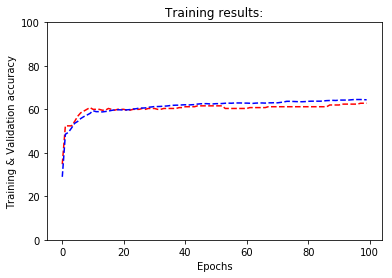

In [70]:
graph = tf.Graph()

random_embedding = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)
    
x, y, W_weights, V_weights, b, c, h, u, p = create_model()    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p)
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 
        'random_embedding', optimizer, cost, batch_size = 50,
        embedding_trainable = True, print_intermediate = True)
    
    plot_train_test(test_lst, train_lst)
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 53.2000005245


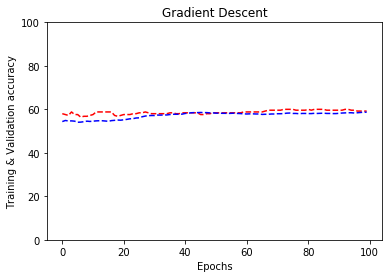

In [73]:
#Training with alternate optimizer
graph = tf.Graph()
    
x, y, W_weights, V_weights, b, c, h, u, p = create_model()    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p, train_method='gradient')
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 'random_embedding', 
        optimizer, cost, embedding_trainable = True, print_intermediate = False)
    
    plot_train_test(test_lst, train_lst, 'Gradient Descent')
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 54.7999978065


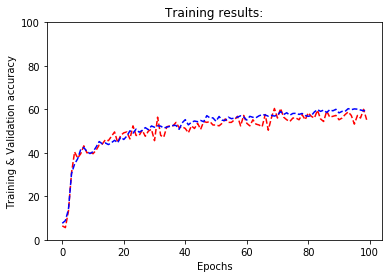

In [74]:
#Training with dropout 0.75
graph = tf.Graph()

random_embedding = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)
    
x, y, W_weights, V_weights, b, c, h, u, p = create_model(dropout_keep_prob = 0.75)    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p)
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 
        'random_embedding', optimizer, cost, batch_size = 50,
        embedding_trainable = True)
    
    plot_train_test(test_lst, train_lst)
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 51.599997282


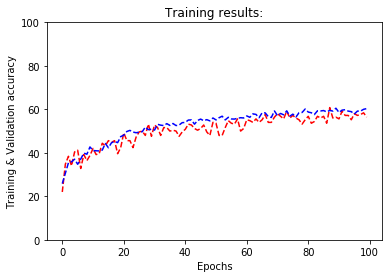

In [76]:
#Training with dropout 0.5
graph = tf.Graph()

random_embedding = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)

x, y, W_weights, V_weights, b, c, h, u, p = create_model(dropout_keep_prob = 0.50)    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p)
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 
        'random_embedding', optimizer, cost, batch_size = 50,
        embedding_trainable = True)
    
    plot_train_test(test_lst, train_lst)
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 54.7999978065


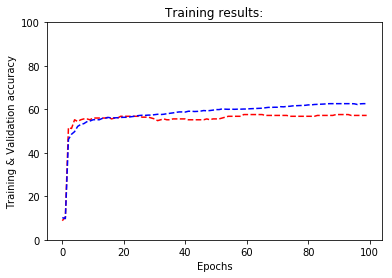

In [77]:
#Training with ReLU
graph = tf.Graph()

random_embedding = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)

x, y, W_weights, V_weights, b, c, h, u, p = create_model(non_linearity='relu')    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p)
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 
        'random_embedding', optimizer, cost, batch_size = 50,
        embedding_trainable = True)
    
    plot_train_test(test_lst, train_lst)
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 58.3999991417


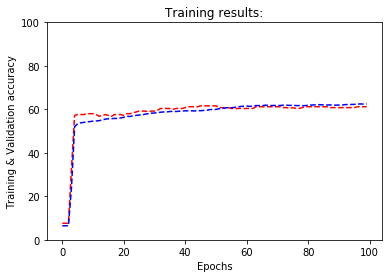

In [78]:
#Training with sigmoid
graph = tf.Graph()

random_embedding = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)

x, y, W_weights, V_weights, b, c, h, u, p = create_model(non_linearity='sigmoid')    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p)
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 
        'random_embedding', optimizer, cost, batch_size = 50,
        embedding_trainable = True)
    
    plot_train_test(test_lst, train_lst)
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 53.2000005245


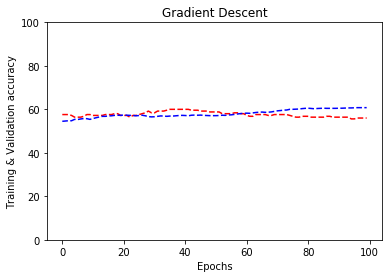

In [79]:
#Vary hidden layer size. Here size = 16
graph = tf.Graph()
    
x, y, W_weights, V_weights, b, c, h, u, p = create_model(hidden_size = 16)    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p, train_method='gradient')
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 'random_embedding', 
        optimizer, cost, embedding_trainable = True, print_intermediate = False)
    
    plot_train_test(test_lst, train_lst, 'Gradient Descent')
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 53.6000013351


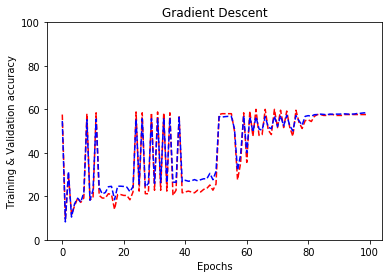

In [84]:
#Hidden layer size = 128
graph = tf.Graph()
    
x, y, W_weights, V_weights, b, c, h, u, p = create_model(hidden_size = 128)    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p, train_method='gradient')
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 'random_embedding', 
        optimizer, cost, embedding_trainable = True, print_intermediate = False)
    
    plot_train_test(test_lst, train_lst, 'Gradient Descent')
    
session.close()

## Visualisation

The rows of the projection matrix V correspond to the vector for each labelling. We can visualise this in 2 dimensions with the tSNE visualisation:

In [81]:
import sklearn

In [82]:
#tSNE visualisation

#Get each row of V, project onto tSNE

graph = tf.Graph()

random_embedding = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), trainable = True)
    
x, y, W_weights, V_weights, b, c, h, u, p = create_model()    
cost, optimizer, predict, accuracy = get_evaluators(u, y, p)
    
with tf.Session() as session:
    train_lst, test_lst = train(session, graph, random_embedding, 
        'random_embedding', optimizer, cost, embedding_trainable = True, print_intermediate = False)
    
    from sklearn.manifold import TSNE

    model = TSNE()
    tsnefit = model.fit_transform(np.transpose(V_weights.eval(session=session)))
    
    #Now scatter plot the rows for each corresponding label.
    labels = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'oED', 'ToD', 'TED']
    
    p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="T-SNE for TED classifications")

    source = ColumnDataSource(data=dict(x1=tsnefit[:,0],
                                        x2=tsnefit[:,1],
                                        names=labels))

    p.scatter(x="x1", y="x2", size=8, source=source)

    labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')
    p.add_layout(labels)

    show(p)
    
session.close()

Initialised training.
Runing:  31  batches of size  50
Training finished: 
Final accuracy: 57.9999983311
